"It is my experience that proofs involving matrices can be shortened by 50% if one throws the matrices out." 
                                             - Emil Artin

The fundamental maths behind neural networks seems complicated, especially if you don't have experience with matricies. But don't you worry, I wrote my first neural network from scratch when I was 15, having never seen a matrix before. A significant portion was bodged together so this is for you, 15 year old IDT, and anyone else who wants to understand neural networks using only high school maths.

What's my secret, you ask? Throwing out the matricies. We'll build up to them naturally, once you've learnt how the operations work without them.

For prerequisites, you'll need to understand how to take the derivative of a value, like $\frac{\delta}{\delta x} 3x^2+2x+1=6x+2$ 

As well as how the chain rule works, like $\frac{\delta}{\delta y}(1-y)^2=-2(1-y)$

You'll also need the Python numpy and matplotlib libraries installed



Firstly, we'll be writing a simple linear regression algorithm using a technique called stochastic gradient descent linear regression. We'll take an input function $y=f(x)$, and attempt to determine its gradient and y intercept by using the exact same techniques as a neural network. 

We'll do this first example without any matricies, so you can develop an intuitive understanding of how everything fits together. 

Let's start by importing the necessary libraries and setting our seed to ensure any changes to our results are because of changes to the algorithm instead of luck

In [45]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

Next, we'll plot a series of scattered points following a line of best fit by defining y=mx+c then adding some noise to create a realistic cluster of values, like how real world measurements also have variance 

In [46]:
# y = mx + c
true_m = 0.4
true_c = 2

start = 0
end = 20
N = 50
x_values = np.linspace(start,end,N)

Now let's inspect $x\_values$ so we know what we're working with - always check your data like this, you need to know how data is structured to work on it. We can see it's a series of $N$ equally distributed points from $start$ to $end$. We always use $N$ to represent the number of data points in a dataset / batch, so be sure to look out for it 

In [47]:
x_values

array([ 0.        ,  0.40816327,  0.81632653,  1.2244898 ,  1.63265306,
        2.04081633,  2.44897959,  2.85714286,  3.26530612,  3.67346939,
        4.08163265,  4.48979592,  4.89795918,  5.30612245,  5.71428571,
        6.12244898,  6.53061224,  6.93877551,  7.34693878,  7.75510204,
        8.16326531,  8.57142857,  8.97959184,  9.3877551 ,  9.79591837,
       10.20408163, 10.6122449 , 11.02040816, 11.42857143, 11.83673469,
       12.24489796, 12.65306122, 13.06122449, 13.46938776, 13.87755102,
       14.28571429, 14.69387755, 15.10204082, 15.51020408, 15.91836735,
       16.32653061, 16.73469388, 17.14285714, 17.55102041, 17.95918367,
       18.36734694, 18.7755102 , 19.18367347, 19.59183673, 20.        ])

Now we'll put all of those values through the equation defined above and add some noise.

In [48]:
# y = mx + c
true_y = true_m * x_values + true_c

# generating random noise 
std_dev = 0.5  # controls the spread
noise = np.random.normal(0, std_dev, size=N) # generates N points of normally distributed noise 
y_noisy = true_y + noise

Now we have some data to predict, let's inspect it using matplotlib

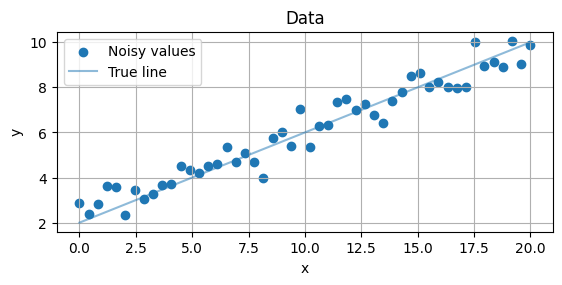

In [51]:
# define our plot
fig,ax = plt.subplots()

#Formatting 
ax.set_title('Data')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()

ax.set_aspect('equal') # Set aspect ratio for equal unit scaling


# plotting the data with noise as a scatter plot
ax.scatter(x_values,y_noisy,label='Noisy values')
# plotting the expected line as a translucent blue line
ax.plot(x_values,true_y,label='True line',alpha=0.5)

ax.legend() # do this after adding your labels or else it'll only show a blank legend!
plt.show()

This all looks good, so now we can get to work writing a model to predict the true line using only the noisy input data.

First, a quick definition:
- loss function : a function which calculates a numerical representation of how (in)correct a model's answer is. The bigger the error, the bigger the loss

A neural network is just a big mathematical function. The key principle of artificial neural networks is to feed the model a series of inputs we know the answers for, compare its output to the expected value, and then use some clever calculus to shift its internal values such that it produces a (hopefully) more correct answer next time. 

If we can quantify how wrong our model is using a loss function, then we can take the derivatives $\frac{\delta \text{loss}}{\delta m}$ and $\frac{\delta \text{loss}}{\delta c}$ to find which direction to move each value in to reduce the loss!

But how do we calculate $\frac{\delta \text{loss}}{\delta m}$ and $\frac{\delta \text{loss}}{\delta c}$? We'll start with $\frac{\delta \text{loss}}{\delta m}$, as you'll soon see its answer takes us to $\frac{\delta \text{loss}}{\delta c}$ as well.

First, we'll need to define a loss function. A popular choice in beginner tutorials is Mean Squared Error, as it's easy to take the derivative of and performs well as the square harshly punishes large errors. It is calculated by averaging the square of the difference between each expected (true) and predicted value, or more formally 

$$MSE = \frac{1}{N}(\hat{Y} - Y)^2$$ 
where $\hat{Y}$ is the expected value and $Y$ is the value our model predicted. 

In [ ]:
# MSE in code
def squared_error(y_true,y_pred):
    return (y_true - y_pred)**2

def mean_squared_error(y_true,y_pred):
    return np.mean(squared_error(y_true,y_pred))

Why have we broken this down into two functions?

Most tutorials fail to distinguish between measures which are useful for humans and measures which are useful for robots.

MSE is lovely for humans, as it's a single number which gets lower the better our model does. But our algorithm needs to know which direction to move every prediction in, not just the average of all predictions. That's why, when calculating MSE, we break it down into squared error (for the computer) and mean squared error (for us fleshy humans)

We'll take the derivative of the squared error with respect to our model's predictions, or more formally $ \frac{\delta MSE(\hat{Y} - Y)}{\delta Y}$

Solving $\frac{\delta }{\delta Y}(\hat{Y} - Y)^2$ will require the chain rule. If you're not familiar with the chain rule, please study it briefly first. 

As a reminder, for $f(g(Y))$, $\frac{\delta }{\delta Y}f(g(Y)) = \frac{\delta f(g(Y))}{\delta g(Y)} \times \frac{\delta g(Y)}{\delta Y}$

We can write $f(u)$ as $u^2$, where $u=(\hat{Y} - Y)$ and $g(Y)$ as $(\hat{Y} - Y)$. 

The derivative of $\frac{\delta}{\delta u}f(u) = \frac{\delta }{\delta u} u^2 = 2u$

And the derivative of $\frac{\delta }{\delta Y}g(Y) = \frac{\delta }{\delta Y} (\hat{Y} - Y)=-1$

Multiply them together to get $$\frac{\delta }{\delta Y}f(g(Y)) = \frac{\delta f(g(Y))}{\delta g(Y)} \times \frac{\delta g(Y)}{\delta Y} = 2u \times -1$$

Then substitute $u=(\hat{Y} - Y)$ to get $$2u \times -1 = 2(\hat{Y} - Y) \times -1 = -2(\hat{Y} - Y)$$

And there we have it! $$\frac{\delta }{\delta Y}(\hat{Y} - Y)^2 = -2(\hat{Y} - Y)$$


Let's put that into code.

In [ ]:
def squared_error_derivative(y_true, y_pred):
    return -2*(y_true - y_pred) 


Note the naming convention! I always get tripped up trying to remember abstract names like loss and loss derivative, so I prefer to have exactly what is a derivative of what written out. 